In [8]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
import seaborn as sns
%matplotlib inline



In [54]:
df = pd.read_csv("data/employee_retention_data.csv")

In [5]:
df.head(1)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30


In [6]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [7]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


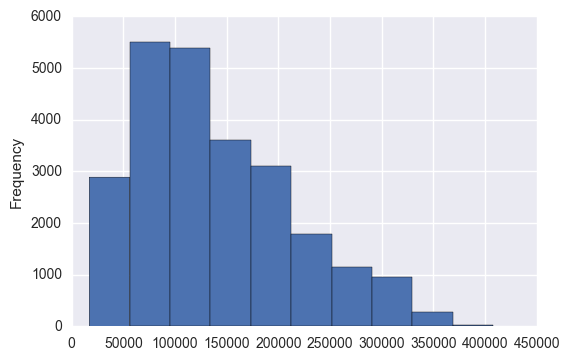

In [13]:
df.salary.plot(kind='hist')

In [15]:
df.seniority.value_counts()

8     1008
12     988
6      950
9      944
2      942
16     936
5      936
7      928
10     927
11     924
14     920
15     911
19     910
4      895
13     894
17     893
3      881
18     872
1      861
20     844
23     785
21     782
22     764
24     743
25     715
26     694
27     642
29     626
28     585
99       1
98       1
Name: seniority, dtype: int64

In [16]:
df[df.seniority > 90]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [17]:
df = df[df.seniority < 90]

In [18]:
df.dept.value_counts()

customer_service    9180
engineer            4612
data_science        3190
sales               3172
marketing           3166
design              1380
Name: dept, dtype: int64

In [55]:
df['ep_duration'] = pd.to_datetime(df.quit_date)-pd.to_datetime(df.join_date)

In [56]:
df['ep_duration'] = (df[~df.ep_duration.isnull()].ep_duration / np.timedelta64(1, 'D')).astype(int)

In [86]:
df['ep_duration'].head(5)

0     585.0
1     340.0
2       NaN
3     389.0
4    1040.0
Name: ep_duration, dtype: float64

In [59]:
df.columns

Index([u'employee_id', u'company_id', u'dept', u'seniority', u'salary',
       u'join_date', u'quit_date', u'ep_duration'],
      dtype='object')

In [125]:
ml_df = df

ml_df['join_date_int'] = (pd.to_datetime(ml_df['join_date']) - pd.to_datetime(ml_df['join_date'].min()))
ml_df.join_date_int =( ml_df.join_date_int / np.timedelta64(1, 'D')).astype(int)


ml_df = ml_df.drop(["employee_id",'join_date','quit_date',"dept"],axis=1)
ml_df = pd.get_dummies(ml_df)

ml_df.head(1)

,company_id,seniority,salary,ep_duration,join_date_int
0,7,28,89000.0,585.0,1155


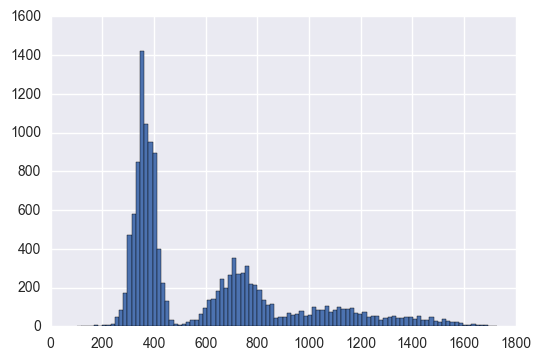

In [122]:

# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()


# plt(min_max_scaler.fit_transform(
        
    
ml_df.ep_duration.hist(bins=100)
# ml_df.ep_duration.plot(kind="kde",color='r')

people dropping at the end of first, second, third year. 

In [131]:
from sklearn.svm import SVR

clf = SVR(kernel="rbf",C=100.0, epsilon=0.01)
clf

ml_df_training = ml_df[~ml_df.ep_duration.isnull()]

X = ml_df_training.drop("ep_duration",axis=1)
#X = ml_df_training[["salary"]]
y = ml_df_training.ep_duration 

Xtrain,Xvalid,ytrain,yvalid = train_test_split( X , y, test_size=0.2, random_state=17)



In [132]:
clf.fit(Xtrain,ytrain)

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [133]:
clf.score(Xvalid,yvalid)

-0.22440723574489319

Regression doesn't seem to be working (tried different features),let's see if we can find a pattern for early quitters?


In [145]:
# classify employees as early quitters

early_quit_df = df 
early_quit_df['early_quit'] = early_quit_df.ep_duration < 366


early_quit_df['join_date_int'] = (pd.to_datetime(early_quit_df['join_date']) - pd.to_datetime(early_quit_df['join_date'].min()))
early_quit_df.join_date_int =( early_quit_df.join_date_int / np.timedelta64(1, 'D')).astype(int)


early_quit_df = early_quit_df.drop(["employee_id",'join_date','quit_date',"dept"],axis=1)
early_quit_df = pd.get_dummies(early_quit_df)

early_quit_df.head(1)

,company_id,seniority,salary,ep_duration,join_date_int,early_quit
0,7,28,89000.0,585.0,1155,False


In [148]:
from sklearn.tree import DecisionTreeClassifier

early_quit_df = early_quit_df.dropna()
X = early_quit_df.drop("early_quit",axis=1)
#X = ml_df_training[["salary"]]
y = early_quit_df.early_quit 

Xtrain,Xvalid,ytrain,yvalid = train_test_split( X , y, test_size=0.2, random_state=17)


tree = DecisionTreeClassifier()
tree.fit(Xtrain,ytrain)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [157]:
def tree_to_code(tree, feature_names):
    global tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

SyntaxError: invalid syntax (<ipython-input-157-00faa7c2e7e3>, line 3)

In [160]:
tree.
tree.feature_importances_

array([ 0.,  0.,  0.,  1.,  0.])

In [161]:
from treeinterpreter import treeinterpreter as ti
prediction, bias, contributions = ti.predict(tree, Xvalid)

In [165]:
assert(np.allclose(prediction, bias + np.sum(contributions, axis=1)))
assert(np.allclose(tree.predict(Xvalid), bias + np.sum(contributions, axis=1)))

ValueError: operands could not be broadcast together with shapes (2702,) (2702,2) 